## This is the softmax workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [6]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [7]:
print(loss)

2.3277607028


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this value make sense?

## Answer:

Because we have 10 classes in this case. Before training this model, the probability of every class to be choosen is the same. That is 1/10. Hence by using loss function, the loss will be -log(1/10) which is 2.3.

#### Softmax gradient

In [8]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.323420 analytic: 0.323420, relative error: 4.340850e-08
numerical: 2.109268 analytic: 2.109267, relative error: 1.393414e-08
numerical: -0.765416 analytic: -0.765417, relative error: 2.377212e-08
numerical: 2.323441 analytic: 2.323441, relative error: 1.049916e-08
numerical: 1.318364 analytic: 1.318364, relative error: 4.979324e-08
numerical: 0.738926 analytic: 0.738925, relative error: 5.682309e-08
numerical: -0.739583 analytic: -0.739583, relative error: 5.397605e-08
numerical: 0.292931 analytic: 0.292931, relative error: 7.089985e-08
numerical: 0.903963 analytic: 0.903963, relative error: 3.482681e-10
numerical: -2.642383 analytic: -2.642383, relative error: 1.297226e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [9]:
import time

In [22]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.2611884461603817 / 256.55325524779994 computed in 0.04638171195983887s
Vectorized loss / grad: 2.261188446160382 / 256.55325524779994 computed in 0.004354953765869141s
difference in loss / grad: -4.440892098500626e-16 /2.3184902617331804e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The way the softmax gradient training step and that of svm is the same. Both use the idea of stochastic gradient descent.

iteration 0 / 1500: loss 2.336592660663754
iteration 100 / 1500: loss 2.055722261347679
iteration 200 / 1500: loss 2.0357745120763413
iteration 300 / 1500: loss 1.9813348165594475
iteration 400 / 1500: loss 1.9583142444066215
iteration 500 / 1500: loss 1.8622653073105446
iteration 600 / 1500: loss 1.8532611454033445
iteration 700 / 1500: loss 1.835306222323703
iteration 800 / 1500: loss 1.829389246837283
iteration 900 / 1500: loss 1.8992158530300574
iteration 1000 / 1500: loss 1.9783503540803116
iteration 1100 / 1500: loss 1.8470797913059949
iteration 1200 / 1500: loss 1.8411450268693184
iteration 1300 / 1500: loss 1.7910402495385682
iteration 1400 / 1500: loss 1.8705803029813195
That took 3.0658533573150635s


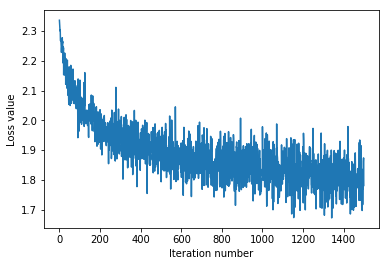

In [15]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [16]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [17]:
np.finfo(float).eps

2.2204460492503131e-16

In [21]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

for learning in learning_rates:
    softmax.train(X_train, y_train, learning_rate=learning, num_iters=1500, verbose=True)
    y_train_pred = softmax.predict(X_train)
    print('learning_rate: {} training accuracy: {}'.format(learning, np.mean(np.equal(y_train,y_train_pred), )))
    y_val_pred = softmax.predict(X_val)
    print('learning_rate: {} validation accuracy: {}'.format(learning, np.mean(np.equal(y_val, y_val_pred)), ))


# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


iteration 0 / 1500: loss 2.2888564871800297
iteration 100 / 1500: loss 33.048102666745365
iteration 200 / 1500: loss 16.46821997275276
iteration 300 / 1500: loss 25.100869938358905
iteration 400 / 1500: loss 38.079963013889056
iteration 500 / 1500: loss 17.3701366375199
iteration 600 / 1500: loss 27.732217308889975
iteration 700 / 1500: loss 39.0332938179829
iteration 800 / 1500: loss 25.071663716943117
iteration 900 / 1500: loss 28.27916388409148
iteration 1000 / 1500: loss 26.462798316540795
iteration 1100 / 1500: loss 29.336807248922064
iteration 1200 / 1500: loss 28.50389380725291
iteration 1300 / 1500: loss 34.867229682167284
iteration 1400 / 1500: loss 38.90287158642168
learning_rate: 0.0001 training accuracy: 0.3006938775510204
learning_rate: 0.0001 validation accuracy: 0.291
iteration 0 / 1500: loss 2.3193958424912204
iteration 100 / 1500: loss 2.7958669979809248
iteration 200 / 1500: loss 3.3521150446484773
iteration 300 / 1500: loss 2.4001322421375217
iteration 400 / 1500: lo

# The softmax.py is shown below

In [ ]:
import numpy as np

class Softmax(object):

  def __init__(self, dims=[10, 3073]):
    self.init_weights(dims=dims)

  def init_weights(self, dims):
    """
	Initializes the weight matrix of the Softmax classifier.  
	Note that it has shape (C, D) where C is the number of 
	classes and D is the feature size.
	"""
    self.W = np.random.normal(size=dims) * 0.0001

  def loss(self, X, y):
    """
    Calculates the softmax loss.
  
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
  
    Inputs:
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
  
    Returns a tuple of:
    - loss as single float
    """

    # Initialize the loss to zero.
    loss = 0.0

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the normalized softmax loss.  Store it as the variable loss.
    #   (That is, calculate the sum of the losses of all the training 
    #   set margins, and then normalize the loss by the number of 
    #   training examples.)
    # ================================================================ #
    
    N = X.shape[0]
    loss = 0
    
    for i in range(N):
        ax_i = self.W.dot(X[i])
        loss -= ax_i[y[i]]
        loss += np.log(np.sum(np.exp(ax_i)))
    loss = loss/N
    
    return loss
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss

  def loss_and_grad(self, X, y):
    """
	Same as self.loss(X, y), except that it also returns the gradient.

	Output: grad -- a matrix of the same dimensions as W containing 
		the gradient of the loss with respect to W.
	"""

    # Initialize the loss and gradient to zero.
    loss = 0.0
    grad = np.zeros_like(self.W)
  
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and the gradient. Store the gradient
    #   as the variable grad.
    # ================================================================ #
    N = X.shape[0]
    C = self.W.shape[0]
    loss = 0
    grad = np.zeros_like(self.W)
    
    for i in range(N):
        ax_i = self.W.dot(X[i])
        loss -= ax_i[y[i]]
        sum_i = np.sum(np.exp(ax_i))
        loss += np.log(sum_i)
        
        for j in range(C):
            p = np.exp(ax_i[j])/sum_i
            grad[j, :] += p * X[i]
            if j == y[i]:
                grad[j, :] -= X[i]

    loss = loss/N
    grad = grad/N    
       
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def grad_check_sparse(self, X, y, your_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in these dimensions.
    """
  
    for i in np.arange(num_checks):
      ix = tuple([np.random.randint(m) for m in self.W.shape])
  
      oldval = self.W[ix]
      self.W[ix] = oldval + h # increment by h
      fxph = self.loss(X, y)
      self.W[ix] = oldval - h # decrement by h
      fxmh = self.loss(X,y) # evaluate f(x - h)
      self.W[ix] = oldval # reset
  
      grad_numerical = (fxph - fxmh) / (2 * h)
      grad_analytic = your_grad[ix]
      rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
      print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

  def fast_loss_and_grad(self, X, y):
    """
    A vectorized implementation of loss_and_grad. It shares the same
	inputs and ouptuts as loss_and_grad.
    """
    loss = 0.0
    grad = np.zeros(self.W.shape) # initialize the gradient as zero
  
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and gradient WITHOUT any for loops.
    # ================================================================ #
    
    A_x = np.dot(self.W, X.T)
    
    N = X.shape[0]
    y_mat = np.zeros_like(A_x)
    y_mat[y, range(N)] = 1   #the row that in y will be 1
    
    correct_wx = np.multiply(y_mat, A_x)
 
    sums_wy = np.sum(correct_wx, axis=0) 

    exp_A_x = np.exp(A_x)
    res = np.log(np.sum(exp_A_x, axis=0))
    res -= sums_wy

    loss = np.sum(res)

    loss /= float(N)

    ###grad 

    grad = exp_A_x / np.sum(exp_A_x, axis=0)
    grad = np.dot(grad, X)
    grad -= np.dot(y_mat, X)

    grad /= float(N)  
    
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in np.arange(num_iters):
      X_batch = None
      y_batch = None

      # ================================================================ #
      # YOUR CODE HERE:
      #   Sample batch_size elements from the training data for use in 
      #      gradient descent.  After sampling,
      #     - X_batch should have shape: (dim, batch_size)
      #     - y_batch should have shape: (batch_size,)
      #   The indices should be randomly generated to reduce correlations
      #   in the dataset.  Use np.random.choice.  It's okay to sample with
      #   replacement.
      # ================================================================ #

      idx = np.random.choice(num_train, batch_size)
      X_batch = X[idx]
      y_batch = y[idx]

      pass
      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      # evaluate loss and gradient
      loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
      loss_history.append(loss)
      
      # ================================================================ #
      # YOUR CODE HERE:
      #   Update the parameters, self.W, with a gradient step 
      # ================================================================ #
      
      self.W -= learning_rate * grad
      pass

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Inputs:
    - X: N x D array of training data. Each row is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    # ================================================================ #
    # YOUR CODE HERE:
    #   Predict the labels given the training data.
    # ================================================================ #
    
    A_x = self.W.dot(X.T)
    y_pred = np.argmax(A_x,axis = 0)
    
    pass
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred

